In [492]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Load models

In [587]:
env_name = "ObstacleAvoidance/"
model_name = "MHGP-BDI/"

iter = "0/1/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
lnr = torch.load(lnr_path)
learner = lnr["learner"]

## state
relative coordinations
- S: shaft
- G: gripper
- State = [(S-G1)[X,Y,Z], (S-G2)[X,Y,Z]]
    - X: horizontal left-right
    - Y: horizontal up-down
    - Z: vertical up-down

In [588]:
for i in range(6):
    print("{0} D have a range MAX:{1} MIN:{2}".format(i,max(lnr["learner"].X[:,i]),min(lnr["learner"].X[:,i])))

0 D have a range MAX:0.14931301772594452 MIN:-0.2952571213245392
1 D have a range MAX:0.007471888791769743 MIN:-0.23376572132110596
2 D have a range MAX:-0.029189573600888252 MIN:-0.29594236612319946
3 D have a range MAX:0.011317956261336803 MIN:-0.4343659579753876
4 D have a range MAX:0.14611347019672394 MIN:-0.09489177912473679
5 D have a range MAX:-0.021916868165135384 MIN:-0.2887387275695801


In [589]:
# Starting point of end effector
    # x: -0.26215904235287263
    # y: 0.3559521601365016
    # z: 0.3846236188507051
starting_posigion_EE = np.array([-0.262, 0.356, 0.385])
shaftA_position = lnr["learner"].X[0][:3] + starting_posigion_EE
shaftB_position = lnr["learner"].X[0][3:6] + starting_posigion_EE

EE_position = shaftA_position - lnr["learner"].X[0][:3]

### Visualization area

- X-axis: shaft_A_x - 0.1[m] <= X <= shaft_A_x + 0.1[m]
- Y-axis: shaft_A_y
- Z-axis: shaft_A_z - 0.1[m] <= Z <= shaft_A_z + 0.4[m]

In [603]:
Sa_x, Sa_y, Sa_z = shaftA_position
Sb_x, Sb_y, Sb_z = shaftB_position
x_range = np.array([Sa_x - 0.15, Sa_x + 0.15])
# x_range = np.array([Sa_x - 0.3, Sa_x + 0.3])
# x_range = np.array([-0.79, -0.3])
# y_range = np.array(Sa_y)
y_range = np.array(Sa_y)+0.05
# z_range = np.array([Sa_z - 0.1, Sa_z + 0.4])
z_range = np.array([-0.0, 0.5])

In [604]:
print("X: ", x_range)
print("Y: ", y_range)
print("Z: ", z_range)
print(Sa_z)
print(Sb_z)

X:  [-0.69504636 -0.39504636]
Y:  0.23233207738399503
Z:  [-0.   0.5]
tensor(0.0997, dtype=torch.float64)
tensor(0.1071, dtype=torch.float64)


In [605]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

In [606]:
def get_traj_fig(dir_fig=str, fig_name=str):
    # No grid line 
    plt.grid(color = 'grey',alpha=0.1)
    # plt.grid(color = 'grey',alpha=0.0)
    # back ground image
    im = plt.imread("Data/Figures/obstacle_avoidance_env.png")
    plt.imshow(im, extent=[x_range[0],x_range[1], z_range[0],z_range[1]],alpha=1.0)

    xticks = torch.linspace(float(x_range[0]),float(x_range[1]), steps=3)
    xticks = np.around(xticks.numpy(),decimals=2)
    zticks = torch.linspace(float(z_range[0]),float(z_range[1]), steps=3)
    zticks = np.around(zticks.numpy(),decimals=2)

    plt.xticks(xticks,alpha=1.0)
    plt.yticks(zticks,alpha=1.0)
    plt.xlabel("X",fontsize=15,labelpad=1)
    plt.ylabel("Z",fontsize=15, labelpad=1)
    plt.savefig(dir_fig + fig_name + '.png',transparent=True)
    # plt.savefig(dir_fig + fig_name + '.pdf')

def get_dpoints_plt(dataset, color="b"):
    """dataset = [N , 2]"""
    # X, Y = dataset[:,0], dataset[:,1]
    X, Y = dataset[:,0][::3], dataset[:,1][::3]
    plt.scatter(X, Y, c=color, s=100, alpha=0.1, marker = 's')

## Heat-map of disturbance level

### Dummy data: end-effctor position -> state
- state: 
    - [0:3] shaftA - EE_position
    - [3:6] shaftB - EE_position

In [626]:
# make these smaller to increase the resolution
res = 0.005
# generate 2 2d grids for the x & y bounds
Y, X = np.mgrid[slice(z_range[0],z_range[1] + res, res),
                slice(x_range[0],x_range[1] + res, res)]

EE_positions = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T)

state1 = torch.stack((Sa_x - EE_positions[:,0],
        Sa_y.repeat(EE_positions.shape[0])-y_range,
        Sa_z - EE_positions[:,1])).T
state2 = torch.stack((Sb_x - EE_positions[:,0],
        Sb_y.repeat(EE_positions.shape[0])-y_range,
        Sb_z - EE_positions[:,1])).T
S = torch.cat((state1,state2),axis=1)

_,_, disturbance = learner.predict(S)
# D = (disturbance **2).sum(1).sqrt()
D = disturbance.mean(1)

(101, 62)
Z-MIN:  tensor(0.0121)


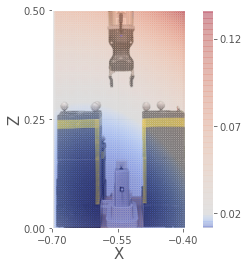

In [634]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
cmap_min = z.min()
cmap_max = z.max()
print("Z-MIN: ",cmap_min)
import matplotlib.colors as colors
# c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.015, vmax=0.03,alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='brg', vmin=0.02, vmax=0.1,alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='bwr', alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=colors.PowerNorm(gamma=0.2, vmin=z.min(), vmax=z.max()))
# divnorm = colors.TwoSlopeNorm(vmin=z.min(), vcenter=z.min()+0.01, vmax=z.max())
divnorm = colors.TwoSlopeNorm(vmin=z.min(), vcenter=0.02, vmax=z.max())
c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=divnorm)

cmap_ticks = np.linspace(cmap_min,cmap_max,3)
cmap_ticks = np.around(cmap_ticks, decimals=3)
# cbar = plt.colorbar(c, ticks=cmap_ticks)
# cbar = plt.colorbar(c, ticks=[0.03, 0.15, 0.27])
cbar = plt.colorbar(c, ticks=[0.02, 0.07, 0.12])

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/obstacle_avoidance/", fig_name='state_dependent'+ str(int(time.time())) )

In [619]:
env_name = "ObstacleAvoidance/"
model_name = "MGP-BDI/"
iter = "0/0/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
homo = torch.load(lnr_path)
homo_lnr = homo["learner"]
homo_noise = (np.exp(homo_lnr.log_sigma[len(homo_lnr.K) - 1]))
print(homo_noise)
homo_noise_level = (homo_noise **2).sum(0).sqrt()
print(homo_noise_level)

tensor([0.2077, 0.2080, 0.2077])
tensor(0.3600)


(101, 62)


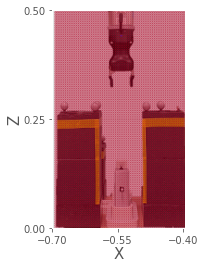

In [622]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
z = z/abs(z)
z *= homo_noise_level
z_min, z_max = z.min(), z.max()
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=colors.PowerNorm(gamma=0.2, vmin=z.min(), vmax=z.max()))
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=0.0, vmax=1.5, alpha=0.6)
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='Reds', vmin=0.0, vmax=0.05, alpha=0.6)

# Normalize data with a set center.
# since hole diameter is 0.02[m],  vcenter is 0.02[m] 
divnorm = colors.TwoSlopeNorm(vmin=cmap_min, vcenter=0.03, vmax=cmap_max)
c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=divnorm)

# plt.colorbar(c)

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/obstacle_avoidance/", fig_name='state_independent'+ str(int(time.time())) )